### Load Data & Featurs

In [33]:
import pandas as pd
import numpy as np
from math import ceil
from matplotlib import pyplot as plt


df = pd.read_csv('merged.csv')
df = df[df['Processor Type'].str.startswith('i')]
df = df[df['Generation'] != 0].reset_index(drop=True)

m, n = df.shape[0], 29

X, y = np.zeros((n, m)), np.zeros(m)
y = df["Price"]

# cpu: 0-4
X[0] = df['Processor Type'] == "i3"
X[1] = df['Processor Type'] == "i5"
X[2] = df['Processor Type'] == "i7"
X[3] = df['Processor Type'] == "i9"
X[4] = df['Generation']

# storage: 5-7
X[5] = df["Disk Drive"] == "Both"
X[6] = df["SSD"]
X[7] = df["HDD"]

# ram: 8-10
X[8] = df["DDR_Version"] == 3
X[9] = df["DDR_Version"] == 4
X[10] = df["RAM_GB"]

# screen: 11-13
X[11] = df["Size(Inches)"]
X[12] = df["Size(Inches)"] ** 2
X[13] = df["Touchscreen"] == "Yes"

# gpu: 14
X[14] = df["Graphic Card"] == "Yes"

# os: 15-16
X[15] = df["Operating System Type"] == "Windows"
X[16] = df["Operating System Type"] == "Mac"

# company: 17-28
companies = df["Company"].unique()
num_co = len(companies)
for i in range(num_co):
    X[17 + i] = df["Company"] == companies[i]

X = X.T

### Functions

In [41]:
def normalized(x):
    mean = np.mean(x, axis=0)
    std_dev = np.std(x, axis=0)
    if np.isscalar(std_dev):
        if std_dev == 0:
            std_dev = 1
    else:
        std_dev[std_dev == 0] = 1
    x_norm = (x - mean) / std_dev
    return x_norm, mean, std_dev

linear_model = lambda w, b, x: np.dot(x, w) + b

def cost_function(w, b, X, y, model):
    f = model(w, b, X)

    return np.sum((f - y) ** 2) / (2 * m)

def gradient_function(w, b, X, y, model, lambda_=0):
    m, n = X.shape
    dj_dw = np.zeros(n)
    dj_db = 0
    error = model(w, b, X) - y
    dj_dw = (np.dot(X.T, error) + lambda_ * w) / m
    dj_db = np.sum(error) / m

    return dj_dw, dj_db

def gradient_descent(w, b, X, y, alpha, model, cost, gradient, num_iters=1000, lambda_=0):
    j_over_iters = np.zeros(num_iters)
    for i in range(num_iters):
        j_over_iters[i] = cost(w, b, X, y, model)
        
        dj_dw, dj_db = gradient(w, b, X, y, model, lambda_)
        w -= alpha * dj_dw
        b -= alpha * dj_db 
        
        if num_iters >= 10 and not i % ceil(num_iters / 10):
            print(f"iter {i}, cost {j_over_iters[i]:.4f}, avg_grad {np.mean(np.abs(dj_dw)):.4f}")
    
    return w, b, j_over_iters

def predict(w, b, x, model, normalized_columns, mean, stdev, y_mean, y_std):
    x = np.atleast_2d(x)
    x_norm = x.copy()
    x_norm[:, normalized_columns] = (x[:, normalized_columns] - mean) / stdev
    y_norm = model(w, b, x_norm)
    y = y_norm * y_std + y_mean

    return y

### Execution

In [42]:
X_norm = X.copy()
to_normalize = [4, 6, 7, 10, 11, 12]
X_norm[:, to_normalize], X_mean, X_std = normalized(X[:, to_normalize])
y_norm, y_mean, y_std = normalized(y)

w = np.zeros(n)
b = 0

w, b, j_history = gradient_descent(
        w, b, X_norm, y_norm, alpha=0.5,
        model=linear_model, 
        cost=cost_function, 
        gradient=gradient_function, 
        num_iters=100,
        lambda_=0.1
)

predicted = predict(w, b, X, linear_model, to_normalize, X_mean, X_std, y_mean, y_std)
print(predicted)

iter 0, cost 0.5000, avg_grad 0.1135
iter 10, cost 0.0645, avg_grad 0.0089
iter 20, cost 0.0515, avg_grad 0.0053
iter 30, cost 0.0463, avg_grad 0.0037
iter 40, cost 0.0435, avg_grad 0.0029
iter 50, cost 0.0416, avg_grad 0.0023
iter 60, cost 0.0402, avg_grad 0.0020
iter 70, cost 0.0391, avg_grad 0.0018
iter 80, cost 0.0381, avg_grad 0.0016
iter 90, cost 0.0374, avg_grad 0.0014
[ 87329.21620206  58844.80952647  67073.29209985  66153.26730408
  57734.29117852  60390.00199355  96201.17350303 122029.46333666
  49297.52312824  56206.45542727  94391.2323305   55480.83327926
  65495.66358452  54845.96773711  59883.39689195  57734.29117852
  59883.39689195  66120.83125584  64001.79517284  60961.47919165
  55326.74965629  49329.95917648  72536.22622899  44043.4063579
  85755.06239762  65495.66358452 123128.1840196   87950.84373206
  57734.29117852  55480.83327926 169317.68347972  49329.95917648
  48219.44082854  60904.70621382  85755.06239762  59055.02312004
  48787.37247257  58844.80952647 1256

### Plots

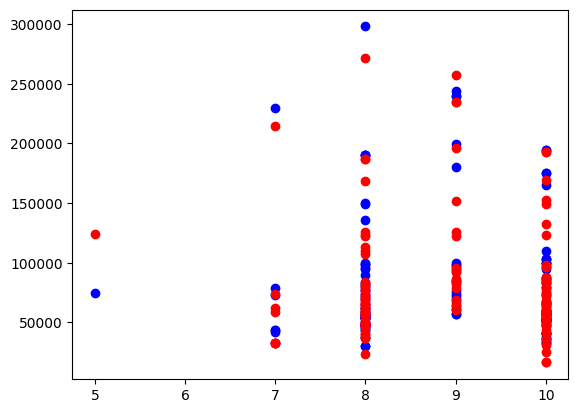

In [43]:
plt.scatter(X[:, 4], y, color='blue')
plt.scatter(X[:, 4], predicted, color='red')
plt.show()

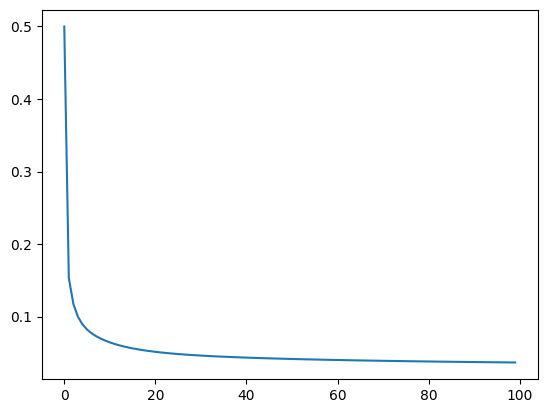

In [44]:
plt.plot(j_history)
plt.show()

### Fitted Prameters

In [45]:
print(f"w = {w}\nb = {b}")

w = [-9.40375828e-02 -1.83798150e-01  7.78548565e-02  3.86078745e-01
 -1.12631084e-02  4.78889277e-04  2.45854588e-01  1.32201889e-01
  2.73850365e-01 -8.77524957e-02  5.29815448e-01 -7.63984410e-02
  1.03887744e-01  4.32102215e-01  1.88336489e-01 -1.57127951e-01
  6.44304299e-01  4.18355359e-02 -3.12503724e-01 -1.80857039e-01
 -1.40990770e-01 -6.14121919e-02 -2.41654101e-01  3.42133143e-01
  3.38750794e-01 -1.37841965e-01  6.55404384e-01 -1.16766197e-01
  0.00000000e+00]
b = 0.19204799701692382
